<a href="https://colab.research.google.com/github/ewi-byte/Metabolic_Pathway_GNN/blob/main/Solution/tutorial5_FBA_exercise1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial #5: Qualitative genome-scale modeling using public data, Flux Balance Analysis (FBA)

Author: Marc Weber  
Date: March 2016  
Affiliation: Center for Genomic Regulation (CRG), Barcelona, Spain.  
Notes: This tutorial was created for the course "Whole-cell modeling", taking place at CRG, Barcelona, April 3-8, 2016.

## Exercise 1: Flux Balance Analysis (FBA)

In this exercise, we will learn to use the COBRA package to compute the optimal growth of E.coli under different conditions using flux balance analysis. We will use the full iJO1366 metabolic model of E.coli (Orth et al. 2011) that takes into accounts 1366 genes, 2251 metabolic reactions and 1136 unique metabolites. We will focus on the glucose central metabolism. The exercises are adapted from the tutorial "What is flux balance analysis?" by Orth, Thiele and Palsson (Orth et al. 2010).

### Outline

- Familiarizing with COBRA and Escher commands.
  - Get and download the iJO1366 from the BiGG database.
  - Loading iJO1366 model.
  - Drawing metabolic map.
  - Altering reaction bounds (adding and/or removing reactions).
  - Change the objective function (typically growth).
  - Solving for fluxes.
  - Draw metabolic map and fluxes using Escher in iPython.
  - Simulating optimal growth.
- Examples:
  - Compute and draw fluxes for aerobic/anaerobic growth on glucose.
  - Growth on alternate substrates
    - compute growth and fluxes on succinate: aerobic / anaerobic (no solution)
    - compute growth and fluxes on puryvate: aerobic / anaerobic (no solution)
  - Simulating different objective function, maximize ATP production.
  - Simulating single gene deletion, gene essentiality
  - Simulating double gene deletions, synthetic lethal

More information:
+ Orth, J. D., Thiele, I., & Palsson, B. Ø. (2010). What is flux balance analysis? Nature Biotechnology, 28(3), 245–248. http://doi.org/10.1038/nbt.1614
+ Maarleveld, T. R., Khandelwal, R. a., Olivier, B. G., Teusink, B., & Bruggeman, F. J. (2013). Basic concepts and principles of stoichiometric modeling of metabolic networks. Biotechnology Journal, 8, 997–1008. http://doi.org/10.1002/biot.201200291
+ Orth, J. D., Conrad, T. M., Na, J., Lerman, J. a, Nam, H., Feist, A. M., & Palsson, B. Ø. (2011). A comprehensive genome-scale reconstruction of Escherichia coli metabolism—2011. Molecular Systems Biology, 7(535), 1–9. http://doi.org/10.1038/msb.2011.65

### Import packages

In [2]:
!pip install escher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 39.1 MB/s eta 0:00:00


In [3]:
!pip install cobra
!pip install cobra.test

ERROR: Could not find a version that satisfies the requirement cobra.test (from versions: none)
ERROR: No matching distribution found for cobra.test


In [5]:
import escher
import escher.urls
import cobra
import json
import os
import pandas
import re
from IPython.display import HTML
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

# If you want to increase the default width of the notebook
#HTML("<style>.container { width:100% !important; }</style>")
# The default height of the metabolic maps as displayed in the notebook
escherDefaultMapHeight = 800

In [ ]:
d = escher.urls.root_directory
print('Escher directory: %s' % d)

Escher directory: /usr/local/lib/python3.11/dist-packages


#### Test COBRA package
All the tests should pass.

In [ ]:
cobra.test.test_all()

AttributeError: module 'cobra' has no attribute 'test'

### Draw metabolic maps with Escher

Escher is a web application for visualizing data on biological pathway maps.

More information:
- King, Z. A., Dräger, A., Ebrahim, A., Sonnenschein, N., Lewis, N. E., & Palsson, B. O. (2015). Escher: A Web Application for Building, Sharing, and Embedding Data-Rich Visualizations of Biological Pathways. PLOS Computational Biology, 11(8), e1004321. http://doi.org/10.1371/journal.pcbi.1004321
- Documentation https://escher.readthedocs.org/en/latest/getting_started.html

List available metabolic maps in the Escher package:

In [ ]:
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

Draw the metabolic map of the textbook example of E. coli central carbon metabolism:

In [ ]:
metabolicMap = escher.Builder(map_name='e_coli_core.Core metabolism')
metabolicMap

Builder()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Draw the map covering the central metabolism part of the full E. coli model iJO1366:

In [ ]:
!jupyter nbextension install --py escher
!jupyter nbextension enable --py escher

Installing /usr/local/lib/python3.11/dist-packages/escher/static -> escher
Up to date: /usr/local/share/jupyter/nbextensions/escher/escher.min.js
Up to date: /usr/local/share/jupyter/nbextensions/escher/extension.js
Up to date: /usr/local/share/jupyter/nbextensions/escher/escher.min.js.map
Copying: /usr/local/lib/python3.11/dist-packages/escher/static/package.json -> /usr/local/share/jupyter/nbextensions/escher/package.json
Making directory: /usr/local/share/jupyter/nbextensions/escher/jsonschema
Copying: /usr/local/lib/python3.11/dist-packages/escher/static/jsonschema/1-0-0 -> /usr/local/share/jupyter/nbextensions/escher/jsonschema/1-0-0
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable escher --py
    
Enabling notebook extension escher/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
   

In [ ]:
builder = escher.Builder()
builder.display_in_notebook()

Exception: display_in_notebook is deprecated. The Builder is now a Jupyter Widget, so you can return the Builder in a cell to see it, or use the IPython display function (see Escher docs for details)

In [ ]:
metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism')
metabolicMap

Builder()

### Get the FBA model from the BiGG database

Browse the BiGG database (http://bigg.ucsd.edu/) and download the iJO1366 metabolic model of E. coli in JSON format. Save the file in the same directory as this ipython notebook.

More information:
+ iJO1366 metabolic model article: Orth, J. D., Conrad, T. M., Na, J., Lerman, J. a, Nam, H., Feist, A. M., & Palsson, B. Ø. (2011). A comprehensive genome-scale reconstruction of Escherichia coli metabolism—2011. Molecular Systems Biology, 7(535), 1–9. http://doi.org/10.1038/msb.2011.65

### COBRApy commands

More information:
+ COBRApy documentation https://cobrapy.readthedocs.org/en/stable/getting_started.html

Load the iJO1366 model with the COBRApy package.

In [ ]:
model = cobra.io.load_json_model('iJO1366.json')

The model contains the lists of reactions, metabolites, and genes, which are attributes of the cobrapy model.

In [ ]:
print('Nb of reactions: ',len(model.reactions))
print('Nb of metabolites: ',len(model.metabolites))
print('Nb of genes: ',len(model.genes))

Nb of reactions:  2583
Nb of metabolites:  1805
Nb of genes:  1367


Just like a regular list, objects in the reactions, metabolites and genes lists can be retrieved by index. For example, to get the 30th reaction in the model,

In [ ]:
model.reactions[29]

Reaction identifier,EX_cpgn_un_e
Name,Coprogen unloaded (no Fe(III)) exchange
Memory address,0x7b44a074d850
Stoichiometry,cpgn_un_e --> Coprogen unloaded (no Fe(III)) -->
GPR,
Lower bound,0.0
Upper bound,1000.0


Additionally, items can be retrieved by their id using the get_by_id() function. For example, consider the reaction glucose 6-phosphate isomerase, which interconverts glucose 6-phosphate and fructose 6-phosphate. The reaction id for this reaction in our model is PGI.

In [ ]:
pgi = model.reactions.get_by_id("PGI")

With an interactive shell such as IPython, reactions can also be retrieved using tab-completion to list elements inside a list. While this is not recommended behavior for most code because of the possibility for characters like “-” inside ids, this is very useful while in an interactive prompt. Start typing `model.reactions.`, then the first characters of the reaction name, and hit tab to get a list of reactions.

In [ ]:
pgi = model.reactions.get_by_id("PGI")

We can view the full name, reaction equation and metabolites with stochiometry as strings.

In [ ]:
print(pgi.name)
print(pgi.reaction)
print(pgi.metabolites)

Glucose-6-phosphate isomerase
g6p_c <=> f6p_c
{<Metabolite f6p_c at 0x7b449a4ec950>: 1.0, <Metabolite g6p_c at 0x7b449a4ee5d0>: -1.0}


We can also view reaction upper and lower bounds. Because the pgi.lower_bound < 0, and pgi.upper_bound > 0, pgi is reversible

In [ ]:
print(pgi.lower_bound, "< pgi <", pgi.upper_bound)
print(pgi.reversibility)

-1000.0 < pgi < 1000.0
True


We define a function to print out the most relevant information about a gene in a cobra model.

In [16]:
def print_gene_info(gene):
    print("cobra_id: ",gene.id)
    print("name: ",gene.name)
    print("associated reactions:")
    for reac in gene.reactions:
        print(f'{reac.id} ({reac.name})')

Try the print function with one gene of the model.

In [17]:
print_gene_info(model.genes.b0841)

cobra_id:  b0841
name:  ybjG
associated reactions:
UDCPDPpp (Undecaprenyl-diphosphatase (periplasm))
UDCPDP (Undecaprenyl-diphosphatase)


### FBA solution

In [ ]:
solution = model.optimize()

Simulations using flux balance analysis can be solved using Model.optimize(). This will maximize or minimize (maximizing is the default) flux through the objective reactions. The Model.optimize() function will return a Solution object, which will also be stored at model.solution. A solution object has several attributes:

+ f: the objective value
+ status: the status from the linear programming solver
+ x_dict: a dictionary of {reaction_id: flux_value} (also called "primal")
+ x: a list for x_dict
+ y_dict: a dictionary of {metabolite_id: dual_value}.
+ y: a list for y_dict

For example, after the last call to model.optimize(), the status should be 'optimal' if the solver returned no errors, and f should be the objective value

In [ ]:
print(dir(solution))
print('Status: ',solution.status)
print('Growth rate: %.2f' % solution.objective_value)
print(solution.fluxes)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_repr_html_', 'fluxes', 'get_primal_by_id', 'objective_value', 'reduced_costs', 'shadow_prices', 'status', 'to_frame']
Status:  optimal
Growth rate: 0.98
EX_cm_e          0.000000
EX_cmp_e         0.000000
EX_co2_e        19.675223
EX_cobalt2_e    -0.000025
DM_4crsol_c      0.000219
                  ...    
RNDR4            0.000000
RNDR4b           0.000000
RNTR1c2          0.025705
RNTR2c2          0.026541
RNTR3c2          0.026541
Name: fluxes, Length: 2583, dtype: float64


### Maximum aerobic growth rate

We want to calculate the maximum aerobic growth of E. coli under the assumption that uptake of glucose, and not oxygen, is the limiting constraint on growth (aerobic conditions).

First we set the maximum glucose uptake rate to 18.5 mmol gDW<sup>-1</sup> h<sup>-1</sup> (millimoles per gram dry cell weight per hour, the default flux units used in the COBRA package). Knowing that the glucose exchange reaction id is `EX_glc__D_e`, print the reactions name, reaction equation, list of metabolites and lower and upper bounds. Then, set the new value of the lower bound to -18.5.

By convention, exchange reactions are written as export reactions (e.g. `glc__D_e <==>`), so import of a metabolite is a negative flux. Maximum uptake rates are therefore expressed as the negative lower bounds of the corresponding exchange reaction with units [mmol gDW<sup>-1</sup> h<sup>-1</sup>].

In [ ]:
glc_exchange = model.reactions.get_by_id('EX_glc__D_e')
print(glc_exchange.name)
print(glc_exchange.reaction)
print(glc_exchange.metabolites)
print(glc_exchange.lower_bound, "< EX_glc__D_e <", glc_exchange.upper_bound)
glc_exchange.lower_bound = -18.5
print(glc_exchange.lower_bound, "< EX_glc__D_e <", glc_exchange.upper_bound)

D-Glucose exchange
glc__D_e <=> 
{<Metabolite glc__D_e at 0x7b449a354350>: -1.0}
-18.5 < EX_glc__D_e < 1000.0
-18.5 < EX_glc__D_e < 1000.0


Second we allow unlimited oxygen uptake. Search the id of the oxygen (O2) uptake reaction of the iJO1366 model in the BiGG database. Change the lower bound of the oxygen uptake reaction to -1000. By setting the lower bound of the oxygen uptake reaction to such a large negative number, it is practically unbounded.

In [ ]:
o2_exchange = model.reactions.get_by_id('EX_o2_e')
print(o2_exchange.name)
print(o2_exchange.reaction)
print(o2_exchange.metabolites)
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)
o2_exchange.lower_bound = -1000
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)

O2 exchange
o2_e <=> 
{<Metabolite o2_e at 0x7b449a355090>: -1.0}
-1000.0 < EX_o2_e < 1000.0
-1000 < EX_o2_e < 1000.0


The objective function is determined from the objective_coefficient attribute of the objective reaction(s). In the iJO1366 model, there are two possible objective reactions, the “core” and “wild-type” biomass reactions. These are reactions that drain biomass precursor compounds in experimentally determined ratios to simulate growth. The “wild- type” biomass reaction contains the precursors to all the typical wild-type cellular components of E. coli, while the “core” biomass reaction contains the precursors only to essential components.

We can find the id's of these reactions by searching for the string "biomass" in the reaction names.

In [ ]:
for reac in model.reactions:
    if re.search('biomass', reac.name, re.I):
        print(reac.name, ', id:', reac.id)

E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate , id: BIOMASS_Ec_iJO1366_WT_53p95M
E. coli biomass objective function (iJO1366) - core - with 53.95 GAM estimate , id: BIOMASS_Ec_iJO1366_core_53p95M


Next, we set the objective function as the core biomass reaction, which contains the precursors only to essential components. The objective function can be set to a specific reaction by using the `model.change_objective` function.

In [9]:
model.objective = model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M

In [ ]:
print(model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.reaction)

0.000223 10fthf_c + 0.000223 2dmmql8_c + 2.5e-05 2fe2s_c + 0.000248 4fe4s_c + 0.000223 5mthf_c + 0.000279 accoa_c + 0.000223 adocbl_c + 0.499149 ala__L_c + 0.000223 amet_c + 0.28742 arg__L_c + 0.234232 asn__L_c + 0.234232 asp__L_c + 54.119975 atp_c + 0.000116 bmocogdp_c + 2e-06 btn_c + 0.004952 ca2_c + 0.000223 chor_c + 0.004952 cl_c + 0.002944 clpn160_p + 0.00229 clpn161_p + 0.00118 clpn181_p + 0.000168 coa_c + 2.4e-05 cobalt2_c + 0.008151 colipa_e + 0.129799 ctp_c + 0.000674 cu2_c + 0.088988 cys__L_c + 0.024805 datp_c + 0.025612 dctp_c + 0.025612 dgtp_c + 0.024805 dttp_c + 0.000223 enter_c + 0.000223 fad_c + 0.006388 fe2_c + 0.007428 fe3_c + 0.255712 gln__L_c + 0.255712 glu__L_c + 0.595297 gly_c + 0.154187 glycogen_c + 0.000223 gthrd_c + 0.209121 gtp_c + 48.752916 h2o_c + 0.000223 hemeO_c + 0.092056 his__L_c + 0.282306 ile__L_c + 0.18569 k_c + 0.437778 leu__L_c + 3e-06 lipopb_c + 0.333448 lys__L_c + 3.1e-05 malcoa_c + 0.149336 met__L_c + 0.008253 mg2_c + 0.000223 mlthf_c + 0.000658 m

Perform FBA with maximization of the biomass reaction as the objective.

In [ ]:
solution = model.optimize()

Growth rate of the optimal solution.

In [ ]:
print('Aerobic conditions.')
print('Satus: ',solution.status)
print('Growth rate: %.2f' % solution.objective_value)

Aerobic conditions.
Satus:  optimal
Growth rate: 1.84


The optimal fluxes accross all reactions can be inspected by printing the attribute x_dict.

In [ ]:
solution.fluxes

,fluxes
EX_cm_e,0.000000
EX_cmp_e,0.000000
EX_co2_e,35.909360
EX_cobalt2_e,-0.000044
DM_4crsol_c,0.000409
...,...
RNDR4,0.000000
RNDR4b,0.000000
RNTR1c2,0.045547
RNTR2c2,0.047029


Draw the fluxes on the metabolic map. We observe that there is high flux in the glycolysis, pentose phosphate, TCA cycle, and oxidative phosphorylation pathways,

In [ ]:
metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              reaction_data=solution.fluxes,
                              # color and size according to the absolute value
                              reaction_styles=['color', 'size', 'abs', 'text'],
                              # change the default colors
                              reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                              {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                              {'type': 'max', 'color': '#ff0000', 'size': 40}],
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.save_html(filepath='/content/map.html')

### Maximum anaerobic growth rate

In order to simulate anaerobic conditions, we set the lower bound of the oxygen uptake reaction to zero, such that no oxygen can enter the system.

In [ ]:
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)
o2_exchange.lower_bound = 0
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)

-1000 < EX_o2_e < 1000.0
0 < EX_o2_e < 1000.0


Perform FBA with maximization of the biomass reaction as the objective.

In [ ]:
solution = model.optimize()
print('Anaerobic conditions.')
print('Satus: ',solution.status)
print('Growth rate: %.2f' % solution.objective_value)

Anaerobic conditions.
Satus:  optimal
Growth rate: 0.48


When `model.optimize()` is used as before, the resulting growth rate is now much lower, 0.48 hr^-1.

Draw the fluxes on the metabolic map. The flux distribution shows that oxidative phosphorylation is not used in these conditions, and that acetate, formate, and ethanol are produced by fermentation pathways

In [ ]:

metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              reaction_data = solution.fluxes,
                              # color and size according to the absolute value
                              reaction_styles=['color', 'size', 'abs', 'text'],
                              # change the default colors
                              reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                              {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                              {'type': 'max', 'color': '#ff0000', 'size': 40}],
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.save_html(filepath='/content/anaerobic_map.html')

### Growth on alternate substrates

Just as FBA was used to calculate growth rates of E. coli on glucose, it can also be used to simulate growth on other substrates. The iJO1366 computational model contains exchange reactions for 324 different compounds, 285 of these compounds contain at least one carbon atom. It is therefore possible to use iJO1366 to predict the growth capabilities of E. coli on a very wide range of media conditions.

As an example, we will simulate growth on succinate instead of glucose.

List all the exchange reactions. Iterate over the reactions and search for the string 'EX' in the reaction id (use `re.search` for string comparison). If the reaction id indicates an exchange reaction, print out the reaction name and id. Print also the total number of exchange reactions.

In [ ]:
i = 0
for reac in model.reactions:
    if re.search(r'^EX', reac.id):
        print(reac.name, ', id:', reac.id)
        i += 1

print('Nb of exchange reactions: ',i)

(R)-Propane-1,2-diol exchange , id: EX_12ppd__R_e
(S)-Propane-1,2-diol exchange , id: EX_12ppd__S_e
1,4-alpha-D-glucan exchange , id: EX_14glucan_e
1,5-Diaminopentane exchange , id: EX_15dap_e
2',3'-Cyclic AMP exchange , id: EX_23camp_e
2',3'-Cyclic CMP exchange , id: EX_23ccmp_e
2',3'-Cyclic GMP exchange , id: EX_23cgmp_e
2',3'-Cyclic UMP exchange , id: EX_23cump_e
2,3-diaminopropionate exchange , id: EX_23dappa_e
Meso-2,6-Diaminoheptanedioate exchange , id: EX_26dap__M_e
2-Dehydro-3-deoxy-D-gluconate exchange , id: EX_2ddglcn_e
3,4-Dihydroxyphenylacetaldehyde exchange , id: EX_34dhpac_e
3'-AMP exchange , id: EX_3amp_e
3'-cmp exchange , id: EX_3cmp_e
3'-GMP exchange , id: EX_3gmp_e
3-hydroxycinnamic acid exchange , id: EX_3hcinnm_e
3-Hydroxypropanoate exchange , id: EX_3hpp_e
3-(3-hydroxy-phenyl)propionate exchange , id: EX_3hpppn_e
3'-UMP exchange , id: EX_3ump_e
4-Aminobutanoate exchange , id: EX_4abut_e
4-Hydroxyphenylacetaldehyde exchange , id: EX_4hoxpacd_e
5-Dehydro-D-gluconate 

#### Aerobic growth on succinate

Search for the succinate exchange reaction id in the list of reactions. Iterate over the reactions and use string comparison `re.search` to search for the reaction name.

In [ ]:
for reac in model.reactions:
    if re.search(r'succinate', reac.name, re.I) and re.search(r'exchange', reac.name, re.I):
        print(reac.name, ', id:', reac.id)

Succinate exchange , id: EX_succ_e


Set the following conditions: aerobic growth (illimited o2 uptake), no glucose and succinate (maximum uptake rate: 20). Then, compute the growth rate and plot the fluxes on the metabolic map.

In [ ]:
# aerobic conditions
o2_exchange.lower_bound = -1000
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)

# No glucose
glc_exchange.lower_bound = 0
print(glc_exchange.lower_bound, "< EX_glc__D_e <", glc_exchange.upper_bound)

# Succinate uptake
succ_exchange = model.reactions.get_by_id('EX_succ_e')
succ_exchange.lower_bound = -20
print(succ_exchange.lower_bound, "< EX_succ_e <", succ_exchange.upper_bound)

solution = model.optimize()
print('Growth rate: %.2f' % solution.objective_value)

# Set back to default values
succ_exchange.lower_bound = 0
glc_exchange.lower_bound = -18.5

metabolicMap.reaction_data=solution.fluxes
metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              reaction_data = solution.fluxes,
                              # color and size according to the absolute value
                              reaction_styles=['color', 'size', 'abs', 'text'],
                              # change the default colors
                              reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                              {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                              {'type': 'max', 'color': '#ff0000', 'size': 40}],
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.save_html(filepath='/content/aerobicSuccinate.html')

-1000 < EX_o2_e < 1000.0
0 < EX_glc__D_e < 1000.0
-20 < EX_succ_e < 1000.0
Growth rate: 1.00


#### Anaerobic growth on succinate

Similarly, we compute the growth rate on succinate under anaerobic conditions.

First, we set the maximum o2 uptake rate to 0.

In [ ]:
# anaerobic conditions
o2_exchange.lower_bound = 0
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)

# No glucose
glc_exchange.lower_bound = 0

# Succinate uptake
succ_exchange.lower_bound = -20

0 < EX_o2_e < 1000.0


Then, we compute the optimal solution and print the status from the solver.

In [ ]:
solution = model.optimize()
print('Status: ',solution.status)

# Set back to default values
succ_exchange.lower_bound = 0
glc_exchange.lower_bound = -18.5

Status:  infeasible


/usr/local/lib/python3.11/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In this case, the optimal solution does not exists and the linear programming solver of the COBRA package returns the status "infeasible". FBA predicts that growth is not possible on succinate under anaerobic conditions, because the maximum amount of ATP that can be produced from this amount of succinate is less than the minimum bound  of the non-growth associated maintenance (NGAM) reaction.

Growth-associated maintenance (GAM) and non-growth-associated maintenance (NGAM) are the amounts of ATP consumed during cell growth and by non-growth associated processes such as maintenance of membrane gradients, respectively. GAM is a component of the biomass reaction, while NGAM is manifest as a lower bound on the separate ATP draining reaction “ATPM.”

<img src="https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/Images/Thiele2010_growth_associated_maintenance_plot.png?raw=1" width="400" />
_Thiele, I., & Palsson, B. Ø. (2010). A protocol for generating a high-quality genome-scale metabolic reconstruction. Nature Protocols, 5(1), 93–121._

Print the lower bound of the ATPM reaction in the iJO1366 model, reaction id `ATPM`.

In [ ]:
model.reactions.ATPM.lower_bound

3.15

The minimum amount of ATP molecules consumed for non-growth maintenance is 3.15 mmol gDW<sup>-1</sup> h<sup>-1</sup>.

#### Growth on pyruvate

Repeat the same steps to compute the growth rate under aerobic and anaerobic conditions on pyruvate.

Hint: to search for the pyruvate exchange reaction, use IPython list tab completion on the `model.reactions` object, knowing that all exchange reactions start with "EX_".

In [ ]:
# aerobic conditions
o2_exchange.lower_bound = -1000
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)

# No glucose
glc_exchange.lower_bound = 0
print(glc_exchange.lower_bound, "< EX_glc__D_e <", glc_exchange.upper_bound)

# Pyruvate uptake
pyruvate_exchange = model.reactions.EX_pyr_e
pyruvate_exchange.lower_bound = -20
print(pyruvate_exchange.lower_bound, "< EX_pyr_e <", pyruvate_exchange.upper_bound)

solution = model.optimize()
print('Growth rate: %.2f' % solution.objective_value)

metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              reaction_data=solution.fluxes,
                              # color and size according to the absolute value
                              reaction_styles=['color', 'size', 'abs', 'text'],
                              # change the default colors
                              reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                              {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                              {'type': 'max', 'color': '#ff0000', 'size': 40}],
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.save_html(filepath='/content/pyruvatemap.html')

-1000 < EX_o2_e < 1000.0
0 < EX_glc__D_e < 1000.0
-20 < EX_pyr_e < 1000.0
Growth rate: 0.73


In [ ]:
# anaerobic conditions
o2_exchange.lower_bound = 0
print(o2_exchange.lower_bound, "< EX_o2_e <", o2_exchange.upper_bound)

# No glucose
glc_exchange.lower_bound = 0

# Pyruvate uptake
pyruvate_exchange.lower_bound = -20

solution = model.optimize()
print('Growth rate: %.2f' % solution.objective_value)

# Set back to default values
glc_exchange.lower_bound = -18.5
succ_exchange.lower_bound = 0
pyruvate_exchange.lower_bound = 0

metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              reaction_data=solution.fluxes,
                              # color and size according to the absolute value
                              reaction_styles=['color', 'size', 'abs', 'text'],
                              # change the default colors
                              reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                              {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                              {'type': 'max', 'color': '#ff0000', 'size': 40}],
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.save_html(filepath='/content/an_pyruvatemap.html')

0 < EX_o2_e < 1000.0
Growth rate: 0.11


### Simulating different objective function: maximize ATP production.

FBA can also be used to determine the maximum yields of important cofactors and biosynthetic precursors from glucose and other substrates.

In this example, we will compute the maximum yields of the cofactors ATP, NADH, and NADPH from glucose under aerobic conditions. To calculate the optimal ATP production, first constrain the glucose exchange reaction to exactly -1 mmol gDW<sup>-1</sup> h<sup>-1</sup> by setting both the lower and upper bounds to -1.

In [ ]:
# aerobic conditions
o2_exchange.lower_bound = -1000

# No other carbon sources
succ_exchange.lower_bound = 0
pyruvate_exchange.lower_bound = 0

# Constrain glucose uptake
glc_exchange.lower_bound = -1
glc_exchange.upper_bound = -1
print(glc_exchange.lower_bound, "< EX_glc__D_e <", glc_exchange.upper_bound)

-1 < EX_glc__D_e < -1


We can check the maximum rate for all the uptake reactions by listing them. Iterate over the reactions and search for reaction that contain exchange in their name and with a non-zero lower bound. Print the reaction bounds, reaction name and id.

In [ ]:
# Print all the uptake reactions with non-zero lower bound
for reac in model.reactions:
    if re.search(r'exchange', reac.name, re.I) and reac.lower_bound < 0:
        print('{: 8.1f} < v < {: 8.1f}'.format(reac.lower_bound, reac.upper_bound),', ', reac.name, ', id:', reac.id)

 -1000.0 < v <   1000.0 ,  Calcium exchange , id: EX_ca2_e
    -0.0 < v <   1000.0 ,  Cob(I)alamin exchange , id: EX_cbl1_e
 -1000.0 < v <   1000.0 ,  Chloride exchange , id: EX_cl_e
 -1000.0 < v <   1000.0 ,  CO2 exchange , id: EX_co2_e
 -1000.0 < v <   1000.0 ,  Co2+ exchange , id: EX_cobalt2_e
 -1000.0 < v <   1000.0 ,  Cu2+ exchange , id: EX_cu2_e
 -1000.0 < v <   1000.0 ,  Fe2+ exchange , id: EX_fe2_e
 -1000.0 < v <   1000.0 ,  Fe3+ exchange , id: EX_fe3_e
    -1.0 < v <     -1.0 ,  D-Glucose exchange , id: EX_glc__D_e
 -1000.0 < v <   1000.0 ,  H+ exchange , id: EX_h_e
 -1000.0 < v <   1000.0 ,  H2O exchange , id: EX_h2o_e
 -1000.0 < v <   1000.0 ,  K+ exchange , id: EX_k_e
 -1000.0 < v <   1000.0 ,  Mg exchange , id: EX_mg2_e
 -1000.0 < v <   1000.0 ,  Mn2+ exchange , id: EX_mn2_e
 -1000.0 < v <   1000.0 ,  Molybdate exchange , id: EX_mobd_e
 -1000.0 < v <   1000.0 ,  Sodium exchange , id: EX_na1_e
 -1000.0 < v <   1000.0 ,  Ammonia exchange , id: EX_nh4_e
 -1000.0 < v <   1000.

Next, set the ATP maintenance reaction (id `ATPM`) as the objective to be maximized using the `change_objective` function. ATPM is a stoichiometrically balanced reaction that hydrolyzes ATP (`atp_c`) and produces ADP (`adp_c`), inorganic phosphate (`pi_c`), and a proton (`h_c`). It works as an objective for maximizing ATP production because in order to consume the maximum amount of ATP, the network must first produce ATP by the most efficient pathways available by recharging the produced ADP.

In [ ]:
model.change_objective('ATPM')
model.reactions.ATPM.reaction

'h2o_c + atp_c --> adp_c + h_c + pi_c'

As we have seen above (anaerobic growth on succinate), by default this reaction has a lower bound of 3.15 mmol gDW<sup>-1</sup> h<sup>-1</sup> to simulate non-growth associated maintenance costs. Remove the constraint on this reaction by setting the lower bounds to 0 and the upper bound to 1000.

In [ ]:
model.reactions.ATPM.lower_bound = 0
model.reactions.ATPM.upper_bound = 1000

Calculate the optimal solution which should give the maximum yield of ATP. Now the optimal objective value is not the biomass production anymore, but rather the flux through the ATP production reaction in units of mmol gDW<sup>-1</sup> h<sup>-1</sup>. Because the uptake rate of glucose has been set to exactly -1 mmol gDW<sup>-1</sup> h<sup>-1</sup>, we can obtain easily the ratio of ATP molecules produced per glucose molecules consumed. The result should be 23.5 mol ATP/mol glucose.

In [ ]:
solution = model.optimize()
print('Maximum ATP production rate:', solution.f, 'mol ATP/mol glucose')

Maximum ATP production rate: 23.500000000014005 mol ATP/mol glucose


In [ ]:
metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              reaction_data=solution.x_dict,
                              # color and size according to the absolute value
                              reaction_styles=['color', 'size', 'abs', 'text'],
                              # change the default colors
                              reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                              {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                              {'type': 'max', 'color': '#ff0000', 'size': 40}],
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.display_in_notebook()

The sensitivity of an FBA solution is indicated by either shadow prices or reduced costs. Shadow prices are the derivative of the objective function with respect to the exchange flux of a metabolite. They indicate how much the addition of that metabolite will increase or decrease the objective. Shadow prices give us an indication of the growth-limiting compounds in the medium.

The reduced cost is a quantity similar to the shadow price, but associated with reactions rather than metabolites. Reduced costs are the derivatives of the objective function with respect to an internal reaction, indicating how much each particular reaction affects the objective.

In the COBRApy package, after computing an optimal solution for a model, shadow prices can be accessed for each metabolite through the y attribute (`metabolite.y`) (see [COBRApy documentation](http://cobrapy.readthedocs.org/en/latest/cobra.core.html#module-cobra.core.Metabolite)). Note that the sign of the `y` attribute should be changed to get the standard interpretation of a positive shadow price: an increase in metabolite uptake (relaxing constraint) leads to a positive increase in the objective function (e.g. biomass production).

More information:
+ Price, N. D., Reed, J. L., Palsson, B. Ø., & Correspondence, B. Ø. P. (2004). Genome-Scale Models of Microbial Cells : Evaluating the Consequences of Constraints, 2(November), 886–897. http://doi.org/10.1038/nrmicro1023
+ Goffin, P., van de Bunt, B., Giovane, M., Leveau, J. H. J., Höppener-Ogawa, S., Teusink, B., & Hugenholtz, J. (2010). Understanding the physiology of Lactobacillus plantarum at zero growth. Molecular Systems Biology, 6(413), 413. http://doi.org/10.1038/msb.2010.67
+ Teusink, B., Wiersma, A., Molenaar, D., Francke, C., De Vos, W. M., Siezen, R. J., & Smid, E. J. (2006). Analysis of growth of Lactobacillus plantarum WCFS1 on a complex medium using a genome-scale metabolic model. Journal of Biological Chemistry, 281(52), 40041–40048. http://doi.org/10.1074/jbc.M606263200

Compute the shadow price of cytosolic proton `h_c` and of glucose `glc__D_c`.

In [ ]:
model.metabolites.h_c.y

0.25

In [ ]:
model.metabolites.glc__D_c.y

-23.500000000000103

As expected, the shadow price of glucose is 23.5 mol ATP/ mol glucose, the same value as we have found above.

ATP production is also limited by cellular proton balancing. The shadow price of cytosolic protons (`h_c`) is -0.25, indicating that the increase of 4 mol protons/mol glucose to the system decreases ATP yield by 1 mol ATP/mol glucose. Protons are produced by various metabolic reactions and are also pumped into the cell by the ATP synthase reaction. In order for the system to be at steady-state, an equal number of protons must be pumped out by the electron transport chain reactions or by excreting metabolites with symporters. If more ATP were to be produced by ATP synthase, it would import additional protons that have no way to escape the cell.

Calculation of NADH and NADPH one at a time can be performed in a similar manner. First, constrain `ATPM` to 0 mmol gDW<sup>-1</sup> h<sup>-1</sup> flux so the cell is not required to produce ATP, and also cannot consume any ATP using this reaction.

In [ ]:
# Constrain glucose uptake
glc_exchange.lower_bound = -1
glc_exchange.upper_bound = -1

# Constrain ATPM reaction flux
model.reactions.ATPM.lower_bound = 0
model.reactions.ATPM.upper_bound = 0

Add stoichiometrically balanced NADH consuming reactions using the function `model.add_reaction`.

Any arbitrary reaction can be defined in the COBRA package. The easiest way to add a new reaction to an existing model is the following:
+ create a `cobra.Reaction` object and set its id to 'NADH_consume' and set its name attribute.
+ add the reaction object to the model using the `model.add_reaction` function
+ define the reaction equation and metabolites by using the `reaction.build_reaction_from_string` function. A simple string containing the reaction equation using the correct metabolites id's is enough to define the metabolites and their stochiometric coefficients.
+ print the newly defined reaction equation

In [ ]:
# Create the reaction object
reaction = cobra.Reaction('NADH_consume')
reaction.name = 'NADH consuming reaction'

# Add the reaction object to the model
model.add_reaction(reaction)

# Define the reaction equation and metabolites using a string. Example met1_c + met2_c -> met3_c
reaction.build_reaction_from_string('nadh_c -> nad_c + h_c', verbose=True)
print(model.reactions.NADH_consume.reaction)

nadh_c --> h_c + nad_c


 Set the NADH consuming reaction as the objective using `model.change_objective`.

In [ ]:
model.change_objective('NADH_consume')

Calculate the optimal solution which should give the maximum yield of NADH. Now the optimal objective value is the flux through the NADH consuming reaction in units of mmol gDW<sup>-1</sup> h<sup>-1</sup>. Because the uptake rate of glucose has been set to exactly -1 mmol gDW<sup>-1</sup> h<sup>-1</sup>, we can obtain easily the ratio of NADH molecules produced per glucose molecules consumed. The result should be 10.29 mol NADH/mol glucose.

In [ ]:
solution = model.optimize()
print('Maximum NADH production rate:', solution.f, 'mol NADH/mol glucose')

Maximum NADH production rate: 10.285714285721184 mol NADH/mol glucose


Then, print the shadow price of cytosolic proton (`h_c`) and ATP (`atp_c`).

In [ ]:
model.metabolites.h_c.y

0.07142857142857295

In [ ]:
model.metabolites.atp_c.y

-14.714285714285722

NADH and NADPH production are also ultimately limited by proton balancing. For
maximum NADH yield, the proton shadow price is -0.07 and ATP shadow price 15.4. The protons produced in metabolism are removed by `ATPS4rpp` in reverse (with a negative flux), which consumes ATP and exports protons to the periplasm. The stoichiometry of the network also limits the production of NADH and NADPH. Glucose has 12 electron pairs that can be donated to redox carriers such as NAD+ or NADP+ , but when the TCA cycle is used, two of these electron pairs are used
to reduce the quinone `q8_c` in the succinate dehydrogenase reaction (`SUCDi`), and thus cannot be used to produce NADH or NADPH. The only pathway that can reduce 12 redox carriers with one molecule glucose is the pentose phosphate pathway, but this is infeasible because this pathway generates no ATP, which is needed to pump out the protons that are produced.

Repeat the same analysis and compute the maximal yield for NADPH. The result should be 9.36 mol NADH/mol glucose.

In [ ]:
# Create the reaction object
reaction = cobra.Reaction('NADPH_consume')
reaction.name = 'NADPH consuming reaction'
# Add the reaction object to the model
model.add_reaction(reaction)
# Define the reaction equation and metabolites using a string. Example A + B -> C
reaction.build_reaction_from_string('nadph_c -> nadp_c + h_c', verbose=True)
print(model.reactions.NADPH_consume.reaction)
# Change objective function to the NADPH_consume reaction
model.change_objective('NADPH_consume')
# Compute optimal solution
solution = model.optimize()
print('Maximum NADPH production rate:', solution.f, 'mol NADPH/mol glucose')

nadph_c --> h_c + nadp_c
Maximum NADPH production rate: 9.363636363636251 mol NADPH/mol glucose


### Gene knockouts and gene essentiality

In [11]:
# Reload the metabolic model with default values
model = cobra.io.load_json_model('iJO1366.json')
model.objective = model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M
# Define aliases for the glucose and oxygen uptake reactions
glc_exchange = model.reactions.get_by_id('EX_glc__D_e')
o2_exchange = model.reactions.get_by_id('EX_o2_e')

Compute the growth in the WT strain with the `model.optimize` function. The default conditions are aerobic growth on glucose with uptake rate of 10 mmol gDW<sup>-1</sup> h<sup>-1</sup>.

In [12]:
solution = model.optimize()
print('WT growth rate: {:.3f} h^-1'.format(solution.objective_value))

WT growth rate: 0.987 h^-1


#### Gene-protein-reaction rules

Just as growth in different environments can be simulated with FBA, gene knockouts can also be simulated by changing reaction bounds. To simulate the knockout of any gene, its associated reaction or reactions can simply be constrained to not carry flux. By setting both the upper and lower bounds of a reaction to 0 mmol gDW<sup>-1</sup> h<sup>-1</sup> , a reaction is essentially knocked out, and is restricted from carrying flux. The E. coli core model, like many other constraint-based models, contains a list of gene-protein-reaction interactions (GPRs), a list of Boolean rules that dictate which genes are connected with each reaction in the model. When a reaction is catalyzed by isozymes (two different enzymes that catalyze the same reaction), the associated GPR contains an “or” rule, where either of two or more genes may be knocked out but the reaction will not be constrained. For example, the GPR for phosphofructokinase (`PFK`) is “b1723 (pfkB) or b3916 (pfkA),” so according to this Boolean rule, both pfkB and pfkA must be knocked out to restrict this reaction. When a reaction is catalyzed by a protein with multiple essential subunits, the GPR contains an “and” rule, and if any of the genes are knocked out the reaction will be constrained to 0 flux. Succinyl-CoA synthetase (SUCOAS), for example, has the GPR “b0728 (sucC) and b0729 (sucD),” so knocking out either of these genes will restrict this reaction. Some reactions are catalyzed by a single gene product, while others may be associated with ten or more genes in complex associations.

The gene-reaction rules can be accessed with the `gene_reaction_rule` attribute of the reaction. Example:

In [13]:
print(model.reactions.PFK.gene_reaction_rule)
print(model.reactions.SUCOAS.gene_reaction_rule)

b3916 or b1723
b0728 and b0729


#### Single gene deletion

The COBRA package contains a function called `single_deletion` that uses the GPRs to constrain the correct reactions and computes the growth rate by FBA optimization. For example, growth can be predicted for E. coli growing aerobically on glucose with the gene _zwf_ (id `b1852`), corresponding to the reaction glucose-6-phosphate dehydrogenase (G6PDH2r), knocked out.

More information:
+ COBRApy documentation http://cobrapy.readthedocs.org/en/latest/deletions.html

First, print the reaction list associated with the _zwf_ gene (id `b1852`). Gene object can be accessed through the `model.genes` dictionary. The `reactions` attribute contains all the reactions that are associated with the gene as a python frozen set. Use a for loop to print all the reactions and their name. In the case of gene `b1852`, there is only one associated reaction.

In [14]:
for reac in model.genes.b1852.reactions:
    print(reac, ' ', reac.name)

G6PDH2r: g6p_c + nadp_c <=> 6pgl_c + h_c + nadph_c   Glucose 6-phosphate dehydrogenase


We have also defined above a function to print out the most relevant information about a gene. It takes as argument the gene object. Try it with the same gene `b1852`.

In [18]:
print_gene_info(model.genes.b1852)

cobra_id:  b1852
name:  zwf
associated reactions:
G6PDH2r (Glucose 6-phosphate dehydrogenase)


Compute the growth rate for the strain with gene _zwf_ gene (id `b1852`) knocked out. The `single_deletion` function is part of the subpackage `cobra.flux_analysis`. It takes as first argument the model object and as second argument a set of gene objects (hint: use `{}` to pass a set of objects).

In [23]:
print('complete model: ', model.optimize())
model.genes.b1852.knock_out()
print('zwf knocked out: ', model.optimize())

complete model:  <Solution 0.980 at 0x78967539ae10>
zwf knocked out:  <Solution 0.980 at 0x789675399a90>


The FBA predicted growth rate of the mutant strain is 0.976 h<sup>-1</sup>, which is slightly lower than the growth rate of 0.982 h<sup>-1</sup> for wild-type E. coli because the cell can no longer use the oxidative branch of the pentose phosphate pathway to generate NADPH.

Using FBA to predict the phenotypes of gene knockouts is especially useful in predicting essential genes. When no alternative pathway or isoenzyme exist to substitute the deleted reactions associated to the knocked out gene, the reported growth rate is zero and the gene is reported as essential in the analysis.

Print the reactions associated with gene _icd_ (`b1136`).

In [ ]:
for reac in model.genes.b1136.reactions:
    print(reac, ' ', reac.name, ' ', reac.reaction)

ICDHyr   Isocitrate dehydrogenase (NADP)   nadp_c + icit_c <=> akg_c + nadph_c + co2_c


Compute the single gene deletion growth rate of gene _icd_ (`b1136`).

In [ ]:
growth_rate, status = cobra.flux_analysis.single_gene_deletion(model, {model.genes.b1136} )
print('icd- growth rate: {:.3f}, status {}'.format(growth_rate['b1136'], status['b1136']))

icd- growth rate: -0.000, status optimal


The gene _icd_ encodes for the enzyme that catalyzes the oxidative decarboxylation of isocitrate, producing $\alpha$-ketoglutarate ($\alpha$-KG) and CO2. The reaction is part of the TCA cycle. Although the TCA cycle allows maximal energy yield from degradation of glucose, its more critical role is to supply precursors for biosynthetic pathways that branch from $\alpha$-ketoglutarate, oxaloacetate, and succinyl CoA. There is only one way to make $\alpha$-KG, so the segment of the cycle leading to $\alpha$-KG is essential.

Draw the metabolic map with the knocked-out reaction highlighted in red.

In [ ]:
model_modified = model.copy()
model_modified.reactions.ICDHyr.delete()
metabolicMap = escher.Builder(map_name='iJO1366.Central metabolism',
                              model=model_modified,
                              # in the map, highlight all reactions that are missing from the model
                              highlight_missing=True,
                              # only show the primary metabolites
                              hide_secondary_metabolites=True)
metabolicMap.display_in_notebook()

More information:
+ Kim, J., & Copley, S. D. (2007). Why metabolic enzymes are essential or nonessential for growth of Escherichia coli K12 on glucose. Biochemistry, 46(44), 12501–12511. http://doi.org/10.1021/bi7014629

<img src="https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/Images/kim2007_metabolic_map_essential_genes.png?raw=1" width="720" />

Legend: _Overview of the central metabolic pathways of E. coli. Pathways are indicated by shading as follows: green for the Embden- Myerhof-Parnase pathway, yellow for the pentose phosphate pathway, pink for the Entner-Doudoroff pathway, and blue for the TCA cycle. Steps catalyzed by enzymes that that are essential for growth on glucose are denoted with red arrows, and the genes are colored red. Genes encoding subunits of multisubunit enzymes are enclosed in brackets. Where deletion of genes encoding two isozymes results in loss of the ability to grow on glucose, the genes are colored blue._

Because FBA can compute phenotypes very quickly, it is feasible to use it for large scale computational screens for gene essentiality, including screens for two or more simultaneous knockouts.

Compute the growth rate of all single gene deletions by passing the list of all genes to the `single_deletion` function, part of the `cobra.flux_analysis` module.

In [ ]:
growth_rates, statuses = cobra.flux_analysis.single_gene_deletion(model, model.genes[:])
list(growth_rates.items())[:30]

[('b1124', 0.9823718127270963),
 ('b2679', 0.9823718127275104),
 ('b0173', 2.4844157970300413e-14),
 ('b0604', 0.982371812726733),
 ('b3493', 0.9823718127319795),
 ('b1521', 0.9823718127272597),
 ('b2133', 0.9823718127306105),
 ('b0963', 0.9823718127270094),
 ('b4367', 0.9823718127265946),
 ('b3390', 0.9823718127267053),
 ('b0308', 0.9823718127306105),
 ('b2585', 3.660352249870054e-14),
 ('b0446', 0.9823718130841728),
 ('b2764', 6.119828503708445e-14),
 ('b0573', 0.9823718127267821),
 ('b3213', 0.9823718127273052),
 ('b1298', 0.9823718127271323),
 ('b1488', 0.9823718127275072),
 ('b0756', 0.9823718127268722),
 ('b0588', 0.9823718127265946),
 ('b3057', 0.9823718127270328),
 ('b1606', 0.98237181272759),
 ('b0070', 0.9823718127306105),
 ('b4154', 0.9823718127266269),
 ('b1492', 0.9823718127271323),
 ('b3774', 5.269621774182355e-15),
 ('b2574', -1.0520064145344347e-10),
 ('b0774', 0.0),
 ('b0928', -1.500313930301208e-13),
 ('b0019', 0.9823718127286469)]

Then, count the number of single gene knockouts that are essential and non-essential. The relatively small fraction of genes that are essential shows the built-in robustness of E. coli metabolism to single-gene deletions.

In [ ]:
# We convert the lists to a pandas dataframe for easier data manipulation
single_gene_deletion_df = pandas.DataFrame.from_dict({"growth_rates": growth_rates, "status": statuses})

growth_rate_threshold = 1e-5
print('Nb of essential genes: ',    len(single_gene_deletion_df[single_gene_deletion_df['growth_rates'] <= growth_rate_threshold]))
print('Nb of non-essential genes: ',len(single_gene_deletion_df[single_gene_deletion_df['growth_rates'] >  growth_rate_threshold]))

Nb of essential genes:  208
Nb of non-essential genes:  1159


#### Double gene deletions (synthetic lethals)

FBA analysis can also be used to compute the effects of knocking down pairs of genes. Synthetic lethals (SL) refer to pairs of non‐essential genes whose simultaneous deletion is lethal. Synthetic gene lethality can arise for a variety of reasons. For example, two gene protein products can be interchangeable with respect to an essential function (isozymes), act in the same essential pathway (with each mutation decreasing the flux through that pathway), or operate in two separate pathways with redundant or complementary essential functions. The study of synthetic lethality plays a pivotal role in elucidating functional associations between genes and gene function predictions.

The identified SL pairs are phenotypically classified into two types. The first type includes the ones that yield auxotrophic strains that can be rescued through the supply of missing nutrients (i.e. amino acids or other compounds), whereas the second type includes those that lack essential functionalities that cannot be restored by adding extra components to the growth medium.

More information:
+ COBRApy documentation http://cobrapy.readthedocs.org/en/latest/deletions.html#double-deletions
+ Suthers, P. F., Zomorrodi, A., & Maranas, C. D. (2009). Genome-scale gene/reaction essentiality and synthetic lethality analysis. Molecular Systems Biology, 5(301), 1–17. http://doi.org/10.1038/msb.2009.56
+ Güell, O., Sagués, F., & Serrano, M. Á. (2014). Essential plasticity and redundancy of metabolism unveiled by synthetic lethality analysis. PLoS Computational Biology, 10(5), e1003637. http://doi.org/10.1371/journal.pcbi.1003637

As an example of the first category of synthetic lethal pair, compute the growth rates of an E. coli strain lacking both cysteine synthase genes _cysK_ (`b2414`), _cysM_ (`b2421`). Double gene deletions can be computed with the `double_deletion` function of the `cobra.flux_analysis` module. The functions takes as argument the cobra model, the list of genes to delete, and the optional argument `return_frame`. The latter optional, when set to `True`, return a pandas frame.

Compute the growth rates for the double deletion.

In [ ]:
double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, {model.genes.b2414, model.genes.b2421}, return_frame=True)
print('cysK- cysM- double knockout growth rates:')
double_deletion_results

cysK- cysM- double knockout growth rates:


,b2421,b2414
b2421,9.823718e-01,1.916506e-12
b2414,1.916506e-12,9.823718e-01


The pair of genes form a synthetic lethal pair, since the growth rate is almost normal when deleting only one of the two genes, while the simultaneous deletion of both genes leads to growth arrest.

The growth can be rescued in silico through the supplementation of the growth medium by L-cysteine (`cys__L_e`). Add this metabolite to the medium by changing the lower bound of its exchange reaction to a small negative amount (reminder: uptake rate are negative) and repeat the double deletion analysis. Observe what happens when changing the uptake rate from -0.05 to -0.5.

In [ ]:
# Supplement the medium with L-cysteine
model.reactions.EX_cys__L_e.lower_bound = -0.2

# Compute double deletion growth rates
double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, {model.genes.b2414, model.genes.b2421}, return_frame=True)
print('cysK- cysM- double knockout growth rates with cysteine-supplemented medium:')

# Set back to the default value
model.reactions.EX_cys__L_e.lower_bound = 0

double_deletion_results

cysK- cysM- double knockout growth rates with cysteine-supplemented medium:


,b2421,b2414
b2421,1.000207,0.806868
b2414,0.806868,1.000207


As a example of the second category of synthetic lethal pair, disruption of modA (`b0763`) and cysA (`b2422`) results in a strain that cannot be rescued through the addition of the missing compound molybdate (`modb_e`) as the gene disruptions eliminate MOB-Dabcpp (molybdate periplasm transport through ABC system) and thus molybdate cannot be imported into the cell.

Print the reaction names associated with the two genes.

In [ ]:
print_gene_info(model.genes.b0763)
print_gene_info(model.genes.b2422)

cobra_id:  b0763
name:  modA
associated reactions:
TUNGSabcpp ,  Tungstate transport via ABC system (periplasm)
SULabcpp ,  Sulfate transport via ABC system (periplasm)
MOBDabcpp ,  Molybdate transport via ABC system (periplasm)

cobra_id:  b2422
name:  cysA
associated reactions:
TSULabcpp ,  Thiosulfate transport via ABC system (periplasm)
SELtpp ,  Selenate transport via proton symport (periplasm)
SULabcpp ,  Sulfate transport via ABC system (periplasm)
SLNTtpp ,  Selenite transport via proton symport (periplasm)
MOBDabcpp ,  Molybdate transport via ABC system (periplasm)



Compute the growth rates for the double deletion.

In [ ]:
double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, {model.genes.b0763, model.genes.b2422}, return_frame=True)
print('modA- cysA- double knockout growth rates:')
double_deletion_results

modA- cysA- double knockout growth rates:


,b0763,b2422
b0763,0.982372,0.000000
b2422,0.000000,0.982372


Compute the growth rates for the double deletion with mobdylate-supplemented (`mobd_e`) medium. The supplementation of mobdylate in the medium cannot rescue growth in the double-deletion mutant.

In [ ]:
# Supplement the medium with mobdylate
model.reactions.EX_mobd_e.lower_bound = -1000

# Compute double deletion growth rates
double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, {model.genes.b0763, model.genes.b2422}, return_frame=True)
print('modA- cysA- double knockout growth rates with mobdylate-supplemented medium:')

# Set back to the default value
model.reactions.EX_mobd_e.lower_bound = -1000

double_deletion_results

modA- cysA- double knockout growth rates with mobdylate-supplemented medium:


,b0763,b2422
b0763,0.982372,0.000000
b2422,0.000000,0.982372


#### Double gene deletion screen

Due to the relatively fast computation speed of FBA, double gene deletion analysis can be performed in a high-throughput manner. As an example, we will perform a double gene knockout screen for all genes involved in the central carbohydrates metabolism.

Because gene annotations are not available in the iJO1366 cobra model, we will retrieve the gene ontology annotations from the EcoCyc database. From the EcoCyc [web interface](http://ecocyc.org), browse the gene ontology and open the class carbohydrate metabolic process (393 instances).
<img src="https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/Images/Ecocyc_1.png?raw=1" width="500" />
Save the gene class as a SmartTable (user account log in is required). In order to list all the genes that are tagged with this gene ontology class, open the new SmartTable and add a transform column "objects annotated to GO terms". Create a new SmartTable from the objects list column (see red arrow).
<img src="https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/Images/Ecocyc_2b.png?raw=1" width="500" />
Add a new property column with the gene name corresponding to each protein.
<img src="https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/Images/Ecocyc_3b.png?raw=1" width="500" />
From the menu of the right, export the SmartTable to a spreadsheet. Choose common names for the format type, as otherwise the gene names are formatted as EcoCyc objectID by default. Move the file to the same dirctory as this notebook and rename it to "EcoCyc_carbohydrate_metabolic_process_GO.xls".

More Information:
+ EcoCyc SmartTable documentation http://biocyc.org/PToolsWebsiteHowto.shtml#node_sec_7

Data tables can be easily imported and handled with the [pandas package](http://pandas.pydata.org/). Pandas brings to Python data structures (dataframe) and data analysis tools similar to R.

Import the table with the `pandas.read_table` function.

In [ ]:
list_genes_GO = pandas.read_table("EcoCyc_carbohydrate_metabolic_process_GO.xls")
# Rename first column
list_genes_GO.rename(columns={list_genes_GO.columns[0]: 'reaction_name'}, inplace=True)
# Drop values with missing gene name (2 cases)
list_genes_GO = list_genes_GO.dropna()
list_genes_GO

,reaction_name,Matches,Gene
0,GLYCOGEN-BRANCH-MONOMER,carbohydrate metabolic process,glgB
1,1-phosphofructokinase monomer,carbohydrate metabolic process,fruK
2,"2,3-bisphosphoglycerate-dependent phosphoglyce...",carbohydrate metabolic process,gpmA
3,"2,3-bisphosphoglycerate-independent phosphogly...",carbohydrate metabolic process,gpmM
4,DEHYDDEOXGALACTKIN-MONOMER,carbohydrate metabolic process,dgoK
5,2-keto-3-deoxy-L-rhamnonate aldolase,carbohydrate metabolic process,yfaU
6,2-keto-3-deoxygluconokinase,carbohydrate metabolic process,kdgK
7,2-ketobutyrate formate-lyase/pyruvate formate-...,carbohydrate metabolic process,tdcE
8,2-methylisocitrate lyase,carbohydrate metabolic process,prpB
9,DEHYDDEOXPHOSGALACT-ALDOL-MONOMER,carbohydrate metabolic process,dgoA


From this list, find the matching genes in the cobra model. Iterate through the genes in the list, and for each gene, search for the gene in the cobra model with the same exact name (use `re.search` function with the case-insensitive option `re.I`). We will use the `apply` function to iterate over the rows of the dataframe.

More information:
+ [stackoverflow post](http://stackoverflow.com/questions/15118111/apply-function-to-each-row-of-pandas-dataframe-to-create-two-new-columns): Apply function to each row of pandas dataframe to create two new columns
+ Pandas documenation: [Merge, join, and concatenate](http://pandas.pydata.org/pandas-docs/stable/merging.html#ignoring-indexes-on-the-concatenation-axis)

In [ ]:
# Define the function to apply at each row of the dataframe
def find_cobra_matching_gene(row):
    cobra_gene = None
    for gene in model.genes:
        if re.search(gene.name, row.Gene, re.I):
            cobra_gene = gene
    found = False if cobra_gene is None else True
    # We must return a pandas.Series in order to be able to add/merge the new columns to the original dataframe
    return pandas.Series({'cobra_gene_found':found,
                          'cobra_gene_object':cobra_gene})

# Apply the function to the rows (axis=1) of the dataframe and add the result as new columns
list_genes_GO2 = list_genes_GO.merge(list_genes_GO.apply(find_cobra_matching_gene, axis=1),
                                     left_index=True, right_index=True)
list_genes_GO2

,reaction_name,Matches,Gene,cobra_gene_found,cobra_gene_object
0,GLYCOGEN-BRANCH-MONOMER,carbohydrate metabolic process,glgB,True,b3432
1,1-phosphofructokinase monomer,carbohydrate metabolic process,fruK,True,b2168
2,"2,3-bisphosphoglycerate-dependent phosphoglyce...",carbohydrate metabolic process,gpmA,True,b0755
3,"2,3-bisphosphoglycerate-independent phosphogly...",carbohydrate metabolic process,gpmM,True,b3612
4,DEHYDDEOXGALACTKIN-MONOMER,carbohydrate metabolic process,dgoK,True,b3693
5,2-keto-3-deoxy-L-rhamnonate aldolase,carbohydrate metabolic process,yfaU,True,b2912
6,2-keto-3-deoxygluconokinase,carbohydrate metabolic process,kdgK,True,b3526
7,2-ketobutyrate formate-lyase/pyruvate formate-...,carbohydrate metabolic process,tdcE,True,b3114
8,2-methylisocitrate lyase,carbohydrate metabolic process,prpB,True,b0331
9,DEHYDDEOXPHOSGALACT-ALDOL-MONOMER,carbohydrate metabolic process,dgoA,True,b4477


Print out how many matching genes were found.

In [ ]:
print("Nb of genes in the carbohydrates metabolism category: ", len(list_genes_GO2))
print("Nb of matching genes in the cobra model: ", len(list_genes_GO2[list_genes_GO2.cobra_gene_found]))
print("Nb of genes absent in the cobra model: ", len(list_genes_GO2[~list_genes_GO2.cobra_gene_found]))

Nb of genes in the carbohydrates metabolism category:  397
Nb of matching genes in the cobra model:  253
Nb of genes absent in the cobra model:  144


The number of matching genes in the cobra model is lower than the number of genes from the EcoCyc database because many genes are not included in the metabolic model. Many of these genes may have unknown function.

Compute the double gene deletion growth rate for the 100 first genes in the list of cobra genes associated to the carbohydrates metabolism GO category.

In [ ]:
gene_list = list(list_genes_GO2[list_genes_GO2.cobra_gene_found].cobra_gene_object)[:90]

double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, gene_list, return_frame=True)
double_deletion_results

,b3432,b2168,b0755,b3612,b3693,b2912,b3526,b3114,b0331,b4477,...,b4232,b3371,b0825,b2800,b2802,b2801,b2255,b3128,b2094,b2093
b3432,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b2168,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b0755,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b3612,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b3693,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b2912,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b3526,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b3114,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b0331,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
b4477,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,...,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372


Plot the resulting growth rate for each of the gene pair double deletion as a 2D heat map.

Some genes are always essential, and result in a growth rate of 0 when knocked out no matter which other gene is also knocked out (horizontal and vertical blue lines). Other genes form synthetic lethal pairs, where knocking out only one of the genes has no effect on growth rate, but knocking both out is lethal (blue squares).

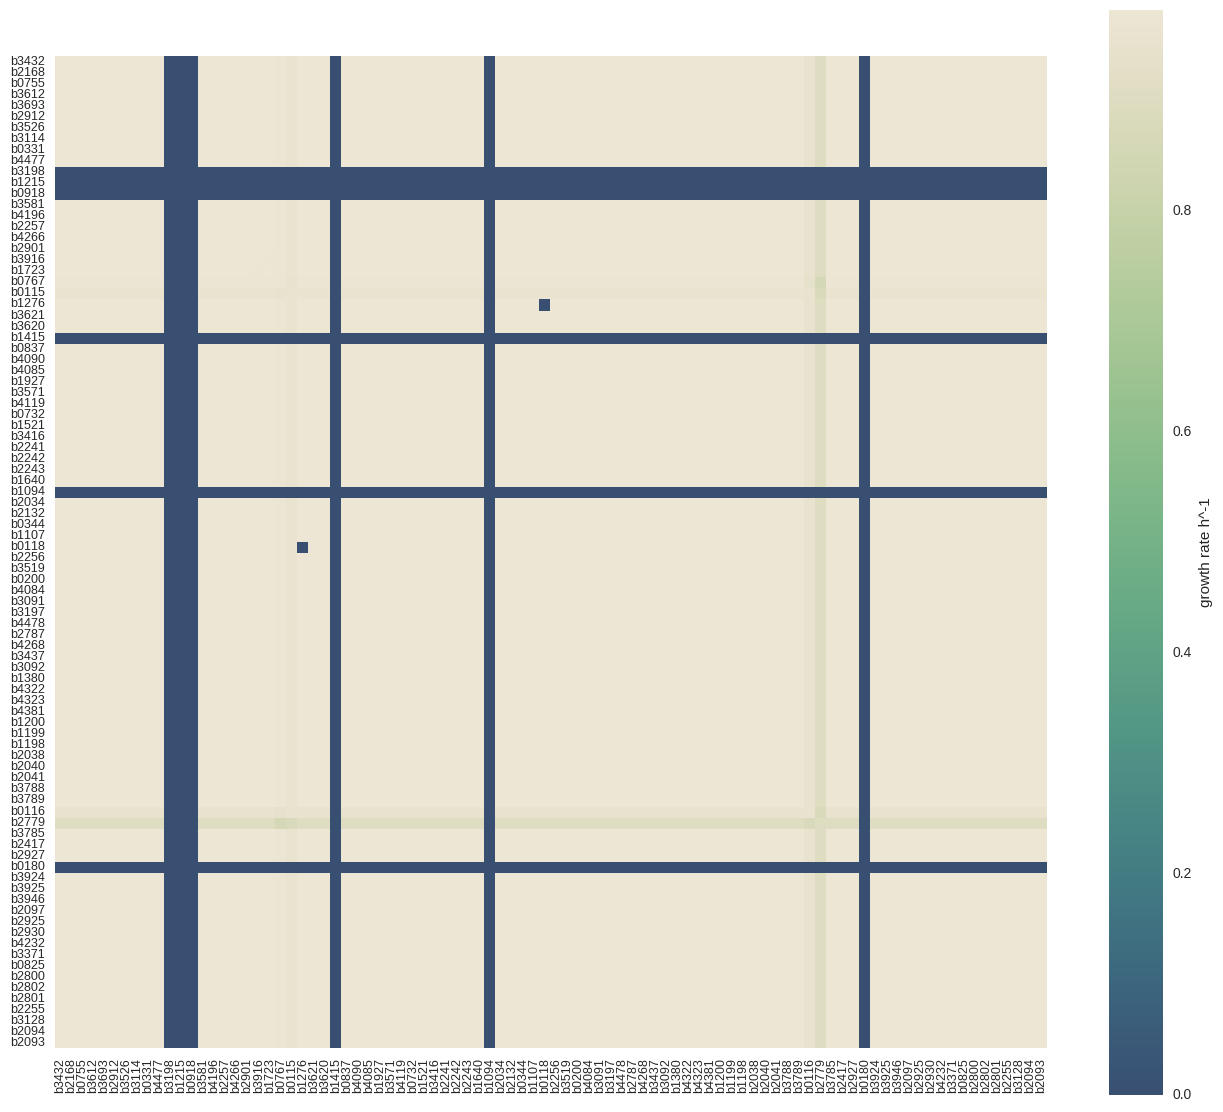

In [ ]:
color_palette = seaborn.cubehelix_palette(8, start=.5, rot=-0.8, dark=0.3, light=0.9, reverse=True, as_cmap=True)
f, ax = plt.subplots(figsize=(16,14))
ax = seaborn.heatmap(double_deletion_results, cmap=color_palette, square=True, linewidths=0,
                     cbar_kws={"label":"growth rate h^-1"})
ax.tick_params(axis='both', which='major', labelsize=9)

From the graph, identify one new synthetic lethal pair, print out the genes information, and compute the growth rates for the corresponding double deletion.

In [ ]:
print_gene_info(model.genes.b1276)
print_gene_info(model.genes.b0118)

cobra_id:  b1276
name:  acnA
associated reactions:
ACONTa ,  Aconitase (half-reaction A, Citrate hydro-lyase)
ACONTb ,  Aconitase (half-reaction B, Isocitrate hydro-lyase)

cobra_id:  b0118
name:  acnB
associated reactions:
ACONTa ,  Aconitase (half-reaction A, Citrate hydro-lyase)
MICITDr ,  2-methylisocitrate dehydratase
ACONTb ,  Aconitase (half-reaction B, Isocitrate hydro-lyase)



In [ ]:
double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, {model.genes.b1276, model.genes.b0118}, return_frame=True)
print('acnA- acnB- double knockout growth rates:')
double_deletion_results

acnA- acnB- double knockout growth rates:


,b0118,b1276
b0118,0.982372,0.000000
b1276,0.000000,0.982372


This synthetic lethal pair was already indentified in a previous version of the E.coli metabolic model, iAF1260 (Suthers et al. 2009) and described experimentally in (Gruer et al. 1997). _acnA_ and _acnB_ genes encode for two aconitases that catalyze the reversible isomerization of citrate and iso-citrate via cis-aconitate. Deletion of both genes leads to a auxotrophic strain that can be rescued through the addition of glutamate in the medium.

<img src="https://github.com/webermarcolivier/metabolic_modelling_jupyter_tutorial/blob/master/Solution/Images/kim2007_metabolic_map_essential_genes.png?raw=1" width="720" />

More information:
+ Suthers, P. F., Zomorrodi, A., & Maranas, C. D. (2009). Genome-scale gene/reaction essentiality and synthetic lethality analysis. Molecular Systems Biology, 5(301), 1–17. http://doi.org/10.1038/msb.2009.56
+ Gruer, M. J., Bradbury, A. J., & Guest, J. R. (1997). Construction and properties of aconitase mutants of Escherichia coli. Microbiology, 143(6), 1837–1846. http://doi.org/10.1099/00221287-143-6-1837
+ Kim, J., & Copley, S. D. (2007). Why metabolic enzymes are essential or nonessential for growth of Escherichia coli K12 on glucose. Biochemistry, 46(44), 12501–12511. http://doi.org/10.1021/bi7014629

Compute the double deletion growth rates when supplementing the medium with glutamate.

In [ ]:
# Supplement the medium with glutamate
model.reactions.EX_glu__L_e.lower_bound = -1

# Compute double deletion growth rates
double_deletion_results = cobra.flux_analysis.double_gene_deletion(model, {model.genes.b1276, model.genes.b0118}, return_frame=True)
print('acnA- acnB- double knockout growth rates in glucose minimal medium supplemented with glutamate:')

# Set back to the default value
model.reactions.EX_glu__L_e.lower_bound = 0

double_deletion_results

acnA- acnB- double knockout growth rates in glucose minimal medium supplemented with glutamate:


,b0118,b1276
b0118,1.057030,0.930066
b1276,0.930066,1.057030
